# Curve Fitting

NLopt does not contain dedicated algorithms for curve fitting but any nonlinear optimization algorithm can be used for that purpose. The ``curve_fit`` function is a simple convenience function to make curve fitting more straightforward. As for general local and global optimization, the API mimics SciPy to make testing different algorithms as simple as possible. Unlike SciPy, all optimization algorithms available in simplenlopt can be employed to perform the fitting.

## Fitting a simple model
In this tutorial we will recreate SciPy's curve fitting [example](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

The model to be fitted has to be supplied as ``f(x, param_1, param_2, ... param_n)`` where ``x`` denotes the independent variable and the other variables the model parameters we want to estimate. The three-parameter model to be fitted is given by an exponential decay plus an offset:

$$
\begin{equation} f(x|a, b, c)=c + a\cdot e^{-b\cdot x} \end{equation}
$$

Least squares fitting means that the sum of the squared differences between the predictions made by the model and the observed data is minimized. In this case:

\begin{equation}
\underset{a, b, c}{\mathrm{argmin}}\sum_i \bigl(f(x_i|a, b, c)-y_i\bigl)^2
\end{equation}

First, we set ground truth parameters, generate a model prediction and add some gaussian noise.

In [1]:
import numpy as np
import simplenlopt
import matplotlib.pyplot as plt

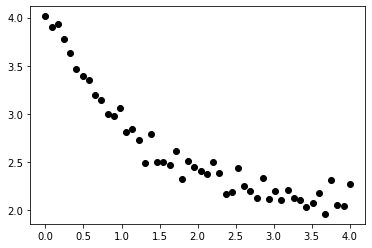

In [2]:
def model(x, a, b, c):

    return a * np.exp(-b * x) + c

xdata = np.linspace(0, 4,50)
a_true = 2.
b_true = 0.8
c_true = 2.
y = model(xdata, a_true, b_true, c_true)
y_data = y + 0.1 * np.random.normal(size=xdata.size)

plt.scatter(xdata, y_data, c = 'k')
plt.show()

Now we can fit the model using the ``curve_fit`` function. Its calling signature is the same as SciPy's: its inputs are at least a Python function which calculates the model prediction and both the independent variable ``xdata`` and the observed data ``ydata``. In case of successsfull optimization it returns the estimated model parameters and the model parameter covariance matrix. The square root of the covariance matrix's diagonal yields an estimate of the model parameter errors. 

Estimated model parameters:  [2.07999203 0.86567334 2.02589507]
Model parameter standard errors:  [0.0049512  0.00579616 0.00388337]


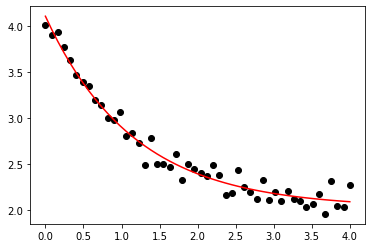

In [3]:
params, cov_matrix = simplenlopt.curve_fit(model, xdata, y_data)
print("Estimated model parameters: ", params)

std_errors = np.sqrt(np.diag(cov_matrix))
print("Model parameter standard errors: ", std_errors)

plt.scatter(xdata, y_data, c = 'k')
plt.plot(xdata, model(xdata, *params), c='r')
plt.show()

Unlike scipy, simplenlopt will use a gradient-free algorithm (BOBYQA) if no gradient information is supplied. Gradient information must be supplied as an N x m numpy array for N data points and m parameters. Each column of the gradient matrix must contain the partial derivative with respect to one parameter for all data points. To make this less confusing, the code below shows how to supply the gradient for this example. The partial derivatives are 
$$
\begin{align}
\frac{\partial f}{\partial a} &=e^{-b\cdot x} \\
\frac{\partial f}{\partial b} &=-x\cdot a\cdot e^{-b\cdot x} \\
\frac{\partial f}{\partial c} &=1
\end{align}
$$

In [4]:
def jac_model(x, a, b, c):

    da = np.exp(-b * x)
    db = -x * a * np.exp(-b * x)
    dc = np.full_like(x, 1.)
    
    return np.stack((da.ravel(), db.ravel(), dc), axis = 1)

params, cov_matrix = simplenlopt.curve_fit(model, xdata, y_data, jac = jac_model)
print("Estimated model parameters: ", params)

Estimated model parameters:  [2.07996431 0.86570146 2.02591902]


## Troubleshooting difficult fits
Next, let's try a more complicated example to show how the choice of optimizers and starting guesses affects the fitting results. We will add a gaussian peak to the model to make it more complex:

\begin{equation} f(x|a, b, c, d, e, f)=c + a\cdot e^{-b\cdot x} +d\cdot \exp\left(\frac{-(e-x)^2}{f^2}\right) \end{equation}

Again, let's first generate some fake data.

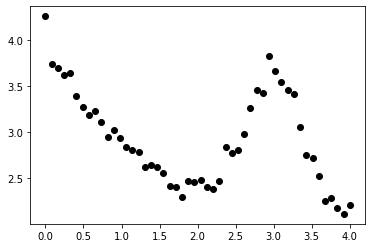

In [5]:
def complex_model(x, a, b, c, d, e, f):

    return a * np.exp(-b * x) + c + d * np.exp(-(e-x)**2/f**2)

d_true = 1.5
e_true = 3.
f_true = 0.5

true_params = np.array([a_true, b_true, c_true, d_true, e_true, f_true])
y_complex = complex_model(xdata, *true_params)
y_noisy = y_complex + 0.1 * np.random.normal(size=xdata.size)
plt.scatter(xdata, y_noisy, c = 'k')

### Initial guess

By default, the initial guess for all model parameters is 1. This guess is far away from the true parameters in this example. A starting point far away from the true parameters also makes it hard for the optimizer to find the true parameters. To illustrate this, let's plot the model prediction for the initial guesses and the parameters found by the default optimizer, BOBYQA.

<ipython-input-5-57e43c5c3f19>:3: RuntimeWarning: divide by zero encountered in true_divide
  return a * np.exp(-b * x) + c + d * np.exp(-(e-x)**2/f**2)


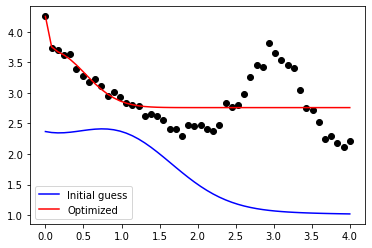

In [6]:
initial_guesses = np.array([1., 1., 1., 1., 1., 1.])
optimized_params, cov_matrix = simplenlopt.curve_fit(complex_model, xdata, y_noisy)
plt.scatter(xdata, y_noisy, c = 'k')
plt.plot(xdata, complex_model(xdata, *initial_guesses), c='b', label='Initial guess')
plt.plot(xdata, complex_model(xdata, *optimized_params), c='r', label='Optimized')
plt.legend()
plt.show()

Ugh, obviously a bad fit. Let's try different starting guesses: we guess the peak position to be at 2.5 and leave the other guesses at 1. The initial guess is passed to the ``p0`` parameter.

<ipython-input-5-57e43c5c3f19>:3: RuntimeWarning: divide by zero encountered in true_divide
  return a * np.exp(-b * x) + c + d * np.exp(-(e-x)**2/f**2)


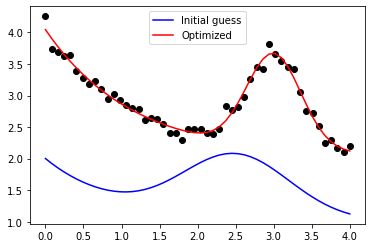

In [7]:
initial_guesses=np.array([1., 1., 1., 1., 2.5, 1.])
optimized_params, cov_matrix = simplenlopt.curve_fit(complex_model, xdata, y_noisy, p0 = initial_guesses)
plt.scatter(xdata, y_noisy, c = 'k')
plt.plot(xdata, complex_model(xdata, *initial_guesses), c='b', label='Initial guess')
plt.plot(xdata, complex_model(xdata, *optimized_params), c='r', label='Optimized')
plt.legend()
plt.show()

This looks much better! Keep in mind that it is always better to supply an initial estimate for the model parameters. If your parameters are far away from 1, fitting will often not work with a local optimizer.

### Choice of the optimization algorithm

That being said, it is also always a good idea to test different optimizers. We will try to fit the model using the default guesses of 1 for all parameters using the Method of Moving Asymptotes (``MMA``) and compare it with the ``BOBYQA`` result.

<ipython-input-5-57e43c5c3f19>:3: RuntimeWarning: divide by zero encountered in true_divide
  return a * np.exp(-b * x) + c + d * np.exp(-(e-x)**2/f**2)
C:\Users\danie\.conda\envs\simplenlopt_env\lib\site-packages\simplenlopt\_Core.py:211: RuntimeWarning: Using gradient-based optimization, but no gradient information is available. Gradient will be approximated by central difference. Consider using a derivative-free optimizer or supplying gradient information.
  warn('Using gradient-based optimization'


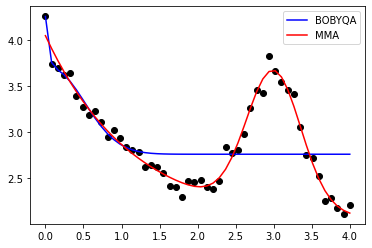

In [8]:
params_bobyqa, bobyqa_cov = simplenlopt.curve_fit(complex_model, xdata, y_noisy, method = 'BOBYQA')
params_mma, mma_cov = simplenlopt.curve_fit(complex_model, xdata, y_noisy, method = 'MMA')
plt.scatter(xdata, y_noisy, c = 'k')
plt.plot(xdata, complex_model(xdata, *params_bobyqa), c='b', label='BOBYQA')
plt.plot(xdata, complex_model(xdata, *params_mma), c='r', label='MMA')
plt.legend()
plt.show()

Clearly, MMA outperforms BOBYQA in this case. As always with nonlinear optimization though, this does not have to be true for all models.

In case of very difficult fits, using a global optimizer can be helpful. All global optimizers available in simplenlopt can be called in ``curve_fit``. Global optimizers require bounds on the parameters: bounds have to be given in the form ``([lower_bound, lower_bound, ...], [upper_bound, upper_bound, ...])`` as a two-tuple which contains a list of lower bounds and a list of upper bounds. Note that this is different from the way bounds are passed to ``minimize`` or the global optimizers: this choice was mandated by the requirement to resemble SciPy's curve fitting API. Here, we will use the Controlled Random Search algorithm (``method='crs'``):

<ipython-input-5-57e43c5c3f19>:3: RuntimeWarning: divide by zero encountered in true_divide
  return a * np.exp(-b * x) + c + d * np.exp(-(e-x)**2/f**2)


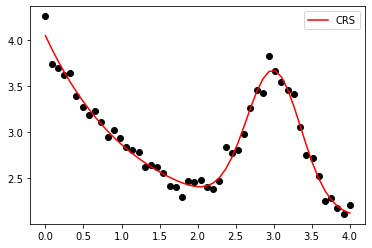

In [9]:
bounds = ([0, 0, 0, 0, 0, 0], [5, 5, 5, 5, 5, 5])
params_crs, crs_cov = simplenlopt.curve_fit(complex_model, xdata, y_noisy, method = 'crs', bounds = bounds)
plt.scatter(xdata, y_noisy, c = 'k')
plt.plot(xdata, complex_model(xdata, *params_crs), c='r', label='CRS')
plt.legend()

## Robust fits for data with outliers

Least-squares fitting is prone to outliers in the data. The influence of outliers can be reduced by choosing a more robust loss function. simplenlopt contains three loss functions indicated by the ``loss`` argument: ``squared``, ``absolute`` and ``cauchy``. For a model with $m$ parameters they are defined as

\begin{align}
\text{'squared':} & \sum_i (f(x_i|p_1, ... , p_m)-y_i)^2\\
\text{'absolute':} & \sum_i |f(x_i|p_1, ... , p_m)-y_i|\\
\text{'cauchy':} & \sum_i f_{scale}^2\cdot \ln\left(1 + \frac{f(x_i|p_1, ... , p_m)-y_i)^2}{f_{scale}^2}\right)
\end{align}

``suared`` yields the typical least squares fit. ``absolute`` error is typically much more robust to outliers but complicates the optimization problem. ``cauchy`` enables to finetune the effect of outliers by varying the ``f_scale`` parameter: the smaller it is, the more robust the fit becomes.

In the following, we will compare the three different losses for fitting the exponential decay with outliers.

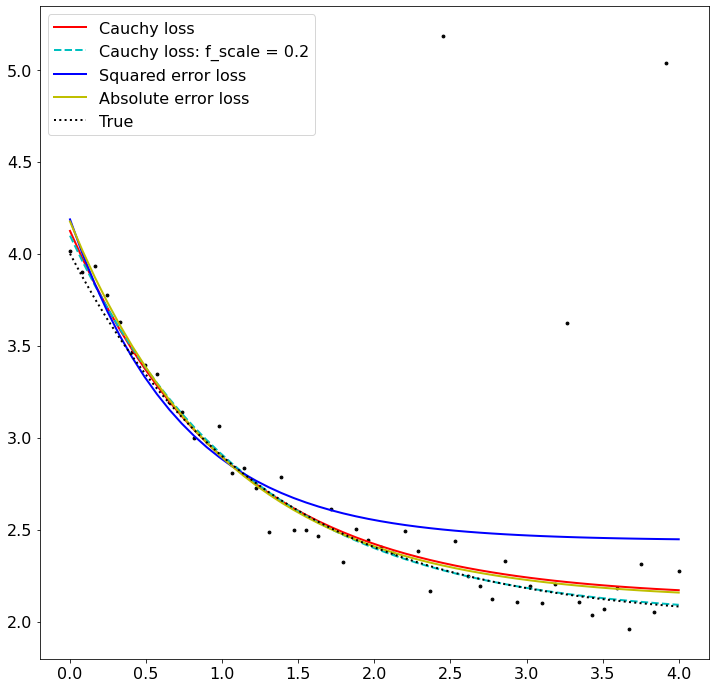

In [13]:
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['font.size']= 16
y_data[30] +=3.
y_data[40] +=1.5 
y_data[48] +=3.

params_cauchy_tuned, pcov_cauchy_tuned = simplenlopt.curve_fit(model, xdata, y_data, method='mma', jac=jac_model, loss = 'cauchy', f_scale = 0.2)
params_cauchy, pcov_cauchy = simplenlopt.curve_fit(model, xdata, y_data, method='mma', jac=jac_model, loss = 'cauchy')
params_absolute, pcov_absolute = simplenlopt.curve_fit(model, xdata, y_data, method='mma', jac=jac_model, loss = 'absolute')
params_squared, pcov_squared = simplenlopt.curve_fit(model, xdata, y_data, method='mma', jac=jac_model, loss = 'squared')

plt.scatter(xdata, y_data, c='k', s = 8)
plt.plot(xdata, model(xdata, *params_cauchy), c='r', lw = 2, label = 'Cauchy loss')
plt.plot(xdata, model(xdata, *params_cauchy_tuned), c='c', lw = 2, ls='--', label = 'Cauchy loss: f_scale = 0.2')
plt.plot(xdata, model(xdata, *params_squared), c='b', lw = 2, label = 'Squared error loss')
plt.plot(xdata, model(xdata, *params_absolute), c='y', lw = 2, label = 'Absolute error loss')
plt.plot(xdata, model(xdata, 2, 0.8, 2), c='k', lw = 2, ls=':', label = 'True')

plt.legend()
plt.show()

Whereas the squared error estimate (blue curve) is very much off, the other loss functions do much better. In many cases, absolute loss (yellow line) already yields a good fit. If possible, Cauchy loss enables to finetune the fit by testing out different values for ``f_scale``: in this case, setting ``f_scale=0.2`` (dashed cyan line)results in a smaller error compared to the default value of 1 (red line).